In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np

import sys 
from pathlib import Path
sys.path.append(str(Path.cwd().parents[0]))
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import (precision_recall_curve, roc_auc_score, recall_score,precision_score)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src.dataset import finalizing_dataset
from src.preprocessing import building_pipeline
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay

In [3]:
cat_col = json.load(open("categorical_cols.json"))
num_col = json.load(open("numerical_cols.json"))

df = finalizing_dataset()

target = "readmitted_30"
y = df[target]
X = df.drop(columns=[target,'readmitted'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [4]:
GB_pipeline = Pipeline(steps=[
    ("preprocessor", building_pipeline(
        cat_col,
        num_col
    )),
    ("model", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

GB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'num_inpati...
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin',
                                                   'glipizide-metformin',
                                                   'glimepiride-pioglitazone',
                                                   'metformin-rosiglitazone', ...])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

In [5]:
y_prob = GB_pipeline.predict_proba(X_test)[:, 1]

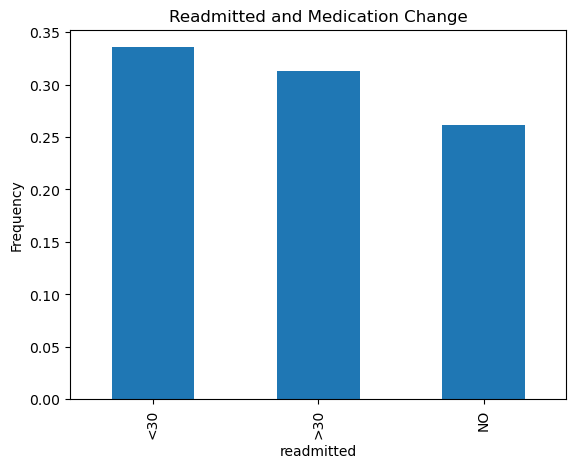

In [17]:
df.groupby('readmitted')['num_medication_change']\
    .mean()\
        .plot(kind='bar')
        
plt.ylabel('Frequency')
plt.title('Readmitted and Medication Change')
plt.show()

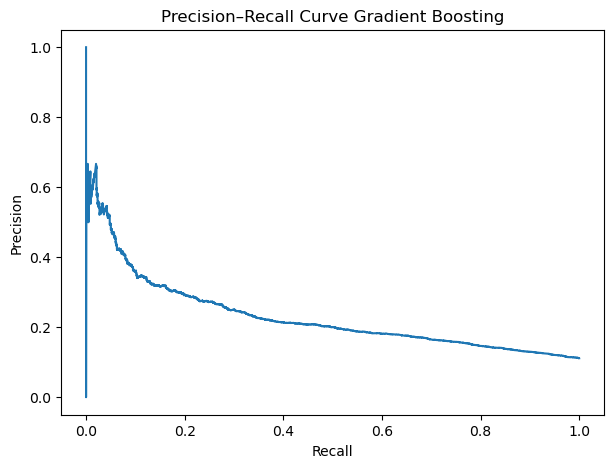

In [6]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Gradient Boosting")
plt.show()

In [7]:
target_recall = 0.5

idx = np.where(recall >= target_recall)[0][-1]
optimal_threshold = thresholds[idx]

optimal_threshold

0.12338987617017036

In [8]:
y_pred_opt = (y_prob >= optimal_threshold).astype(int)

OPT_results = {
    "roc_auc": roc_auc_score(y_test, y_prob),
    "recall": recall_score(y_test, y_pred_opt),
    "precision": precision_score(y_test, y_pred_opt),
    "threshold": optimal_threshold
}

OPT_results


{'roc_auc': 0.6773767728352162,
 'recall': 0.5024218405988551,
 'precision': 0.20024570024570024,
 'threshold': 0.12338987617017036}

In [9]:
json.dump(OPT_results, open("OPT_threshold.json", "w"))

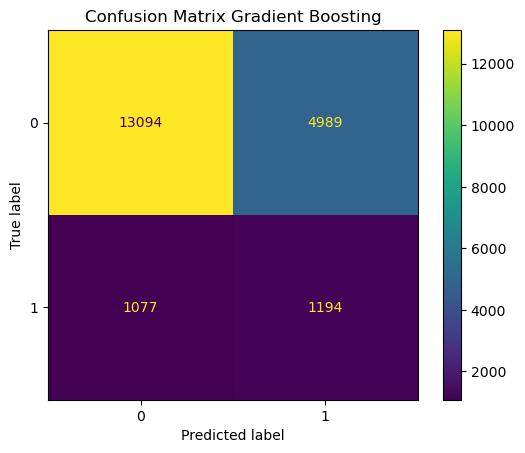

In [10]:
y_pred_fin = (y_prob >= 0.12).astype(int)

cm = confusion_matrix(y_test, y_pred_fin)

disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='d')
plt.title("Confusion Matrix Gradient Boosting")
plt.show()

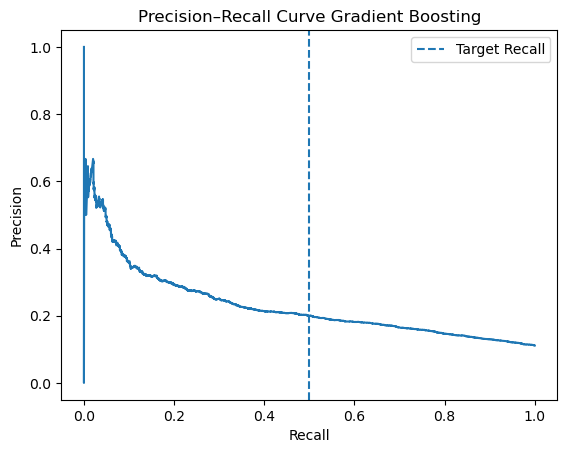

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.axvline(0.5, linestyle='--', label='Target Recall')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Gradient Boosting")
plt.legend()
plt.show()

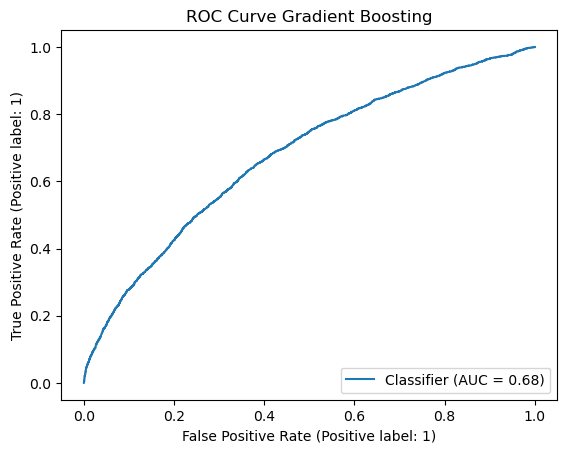

In [12]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve Gradient Boosting")
plt.show()

In [13]:
final_results = pd.DataFrame([{
    "Model": "Gradient Boosting (threshold tuned)",
    "ROC AUC": 0.68,
    "Recall": 0.50,
    "Precision": 0.20,
    "Threshold": 0.12
}])

final_results

,Model,ROC AUC,Recall,Precision,Threshold
0,Gradient Boosting (threshold tuned),0.68,0.5,0.2,0.12


## Interpretability 

In [19]:
preprocessor = GB_pipeline.named_steps['preprocessor']
importances = GB_pipeline.named_steps['model'].feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importance = (pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(15))

feature_importance

,feature,importance
11,num__num_inpatient,0.256624
1,num__discharge_disposition_id,0.219793
9,num__number_inpatient,0.213129
14,num__total_visits,0.033937
725,cat__diag_1_V58,0.024577
17,num__has_diabetes_complications,0.018537
3,num__time_in_hospital,0.016045
10,num__number_diagnoses,0.012326
4,num__num_lab_procedures,0.009161
724,cat__diag_1_V57,0.009089


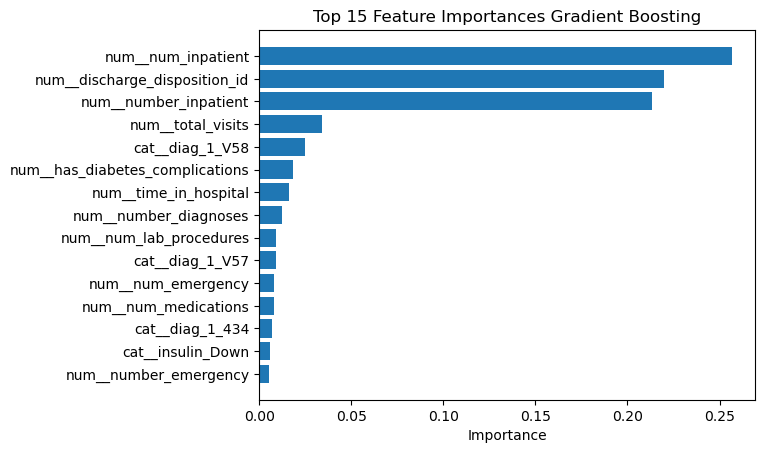

In [15]:
import matplotlib.pyplot as plt

plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances Gradient Boosting")
plt.xlabel("Importance")
plt.show()


 99%|===================| 20176/20354 [00:47<00:00]        

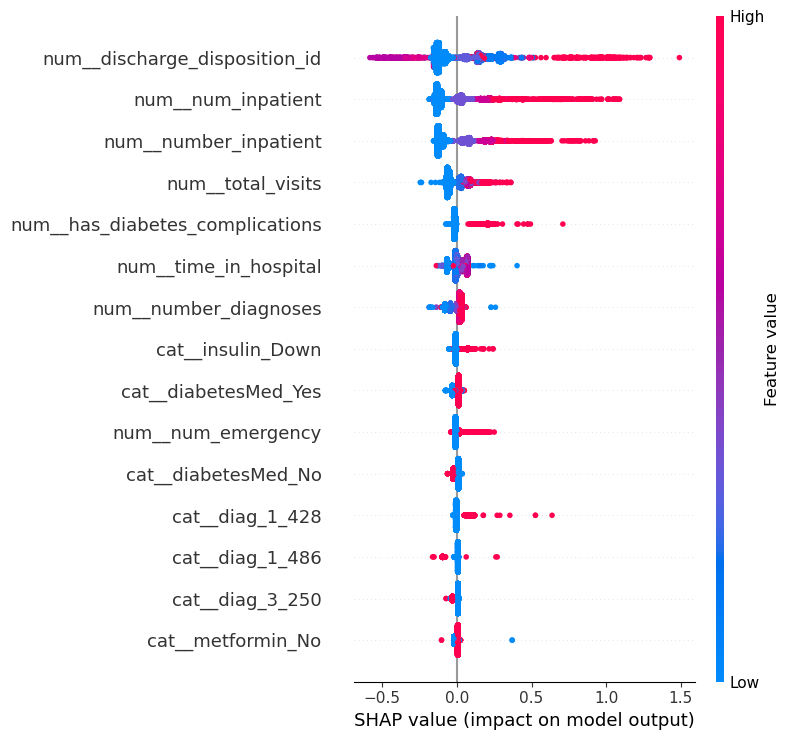

In [ ]:
# Extract trained pieces
preprocessor = GB_pipeline.named_steps["preprocessor"]
model = GB_pipeline.named_steps["model"]

# Transform data
test_transformed = preprocessor.transform(X_test).astype(float)
train_transformed = preprocessor.transform(X_train).astype(float)

# SHAP to show the importance of features and there impact 
explain = shap.TreeExplainer(model, train_transformed)
values = explain.shap_values(test_transformed)

shap.summary_plot(
    values,
    test_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    max_display=15
)

